In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! pip install --upgrade --force-reinstall --no-deps kaggle
! kaggle competitions download -c house-prices-advanced-regression-techniques
! unzip /content/house-prices-advanced-regression-techniques.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns 
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
  pass
warnings.warn = ignore_warn 
from scipy import stats

from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:3f}'.format(x))

from subprocess import check_output

print(check_output(["ls", "../content"]).decode("utf8"))

kaggle.json
sample_data



In [4]:
train = pd.read_csv("../content/train.csv")
test = pd.read_csv("../content/test.csv")

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,CBlock,TA,TA,No,Rec,468.000000,LwQ,144.000000,270.000000,882.000000,GasA,TA,Y,SBrkr,896,0,0,896,0.000000,0.000000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000000,Unf,1.000000,730.000000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000000,TA,TA,CBlock,TA,TA,No,ALQ,923.000000,Unf,0.000000,406.000000,1329.000000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000000,0.000000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000000,Unf,1.000000,312.000000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,No,GLQ,791.000000,Unf,0.000000,137.000000,928.000000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000000,0.000000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000000,Fin,2.000000,482.000000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000000,TA,TA,PConc,TA,TA,No,GLQ,602.000000,Unf,0.000000,324.000000,926.000000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000000,0.000000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000000,Fin,2.000000,470.000000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000000,Unf,0.000000,1017.000000,1280.000000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000000,0.000000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000000,RFn,2.000000,506.000000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
train_ID = train['Id']
test_ID = test['Id']

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

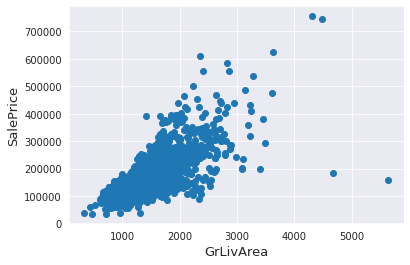

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('SalePrice', fontSize=13)
plt.xlabel('GrLivArea', fontSize=13)
plt.show()

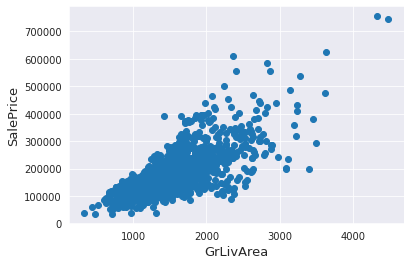

In [9]:
# deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('SalePrice', fontSize=13)
plt.xlabel('GrLivArea', fontSize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



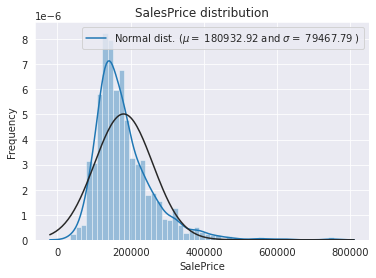

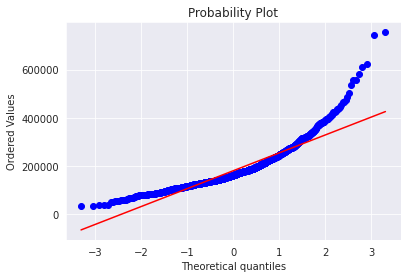

In [10]:
sns.distplot(train['SalePrice'], fit=norm)

mu, sigma = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

plt.ylabel('Frequency')
plt.title('SalesPrice distribution')

#QQ Plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

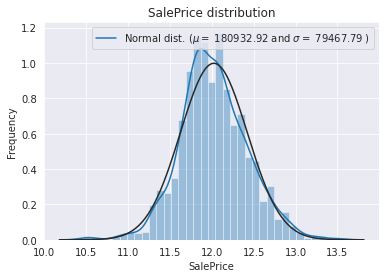

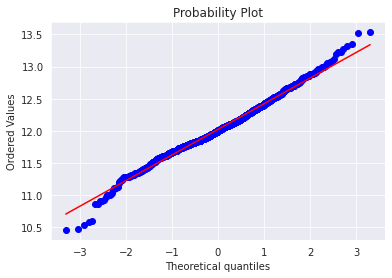

In [11]:
# Log Transformation of the Target Variable

train['SalePrice'] = np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'], fit=norm)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

## QQ Plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [12]:
# Feature Engg

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is :{}".format(all_data.shape))

all_data size is :(2917, 79)


In [14]:
# Missing Data

In [15]:
all_data_na = (all_data.isnull().sum()/len(all_data)*100)
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

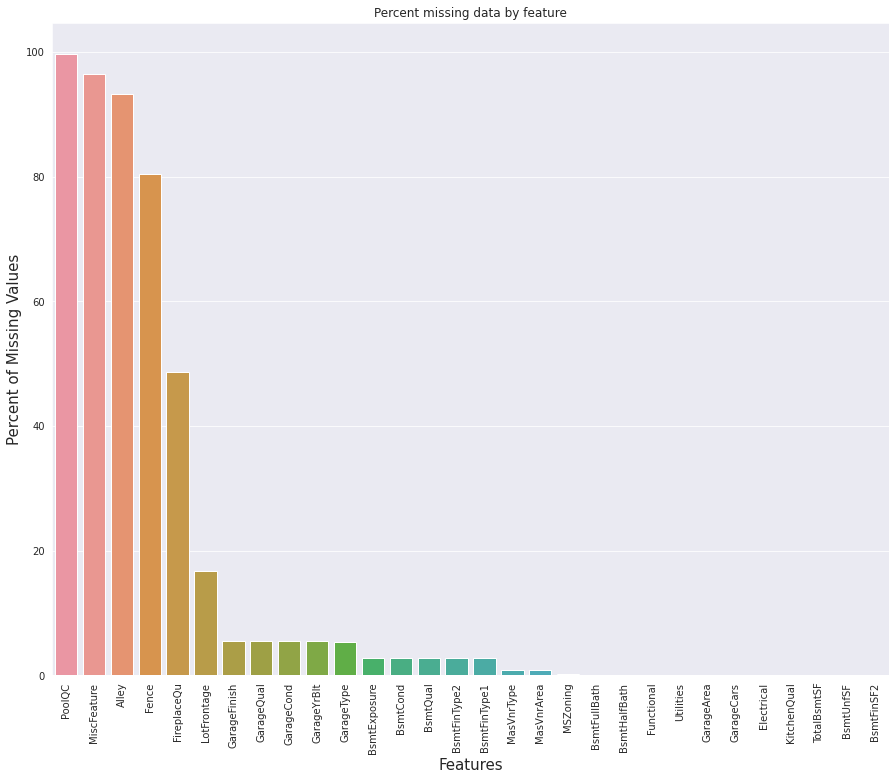

In [16]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Percent missing data by feature')

In [17]:
# Data Correlations

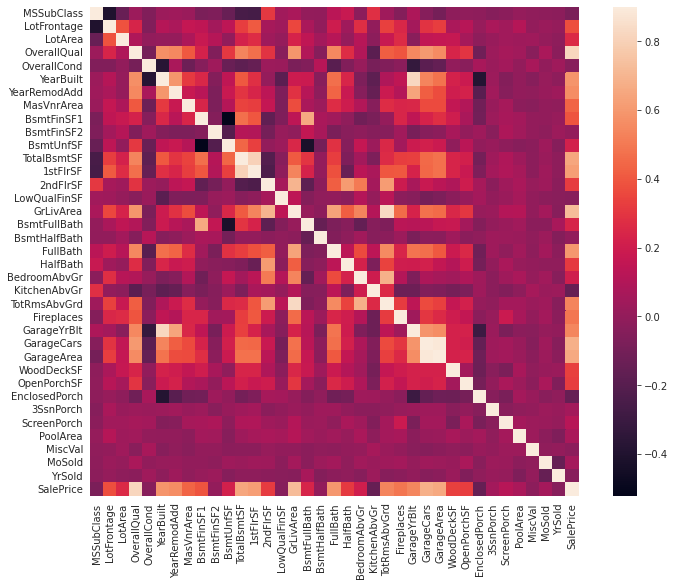

In [18]:
corrmat = train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True )

In [19]:
## Imputing Values

In [20]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')
all_data['MiscFeature'] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()) )

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])


all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [21]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [22]:
## Further Feature Engg

In [23]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [24]:
## Label encoding

In [25]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c] = lbl.transform(list(all_data[c].values))

print('Shape of all_data: {}'.format(all_data.shape))

Shape of all_data: (2917, 78)


In [26]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [27]:
## Skewed Features

In [28]:
numeric_feats = all_data.dtypes[all_data.dtypes!='object'].index

# Checking skewness
skewed_feats = all_data[numeric_feats].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)

print("\nSkewness in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})

skewness.head(10)


Skewness in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [29]:
## BoxCox Transformation for skewed variables

In [31]:
skewness = skewness[abs(skewness)>0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15

for feat in skewed_features:
  all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [35]:
## Dummy Categorial Variables

In [36]:
all_data = pd.get_dummies(all_data)

all_data.shape

(2917, 220)

In [37]:
## Train & Test data
train = all_data[:ntrain]
test  = all_data[ntrain:]

In [38]:
## Creating Models

In [5]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error 
import xgboost as xgb
import lightgbm as lgb

In [1]:
# Validation Function
n_folds = 5

def rmsle_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
  rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_square_error', cv = kf))
  return (rmse)

In [2]:
## Lasso

In [6]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42))

In [7]:
## Elastic Net

In [8]:
enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42))

In [9]:
## Kernel Ridge

In [10]:
krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)